Output sizes: 
(266, 400, 3)
(348, 348, 3)


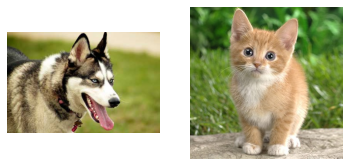

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):

    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].shape)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(Image.fromarray(images[i]))
    plt.show()

images = [
    np.array(Image.open('../assets/dog.jpg')),
    np.array(Image.open('../assets/cat.jpg'))
]
show_images(images)

In [2]:
def preprocess(image):
    # resize so that the shorter side is 256, maintaining aspect ratio
    def image_resize(image, min_len):
        image = Image.fromarray(image)
        ratio = float(min_len) / min(image.size[0], image.size[1])
        if image.size[0] > image.size[1]:
            new_size = (int(round(ratio * image.size[0])), min_len)
        else:
            new_size = (min_len, int(round(ratio * image.size[1])))
        image = image.resize(new_size, Image.BILINEAR)
        return np.array(image)
    image = image_resize(image, 256)

    # Crop centered window 224x224
    def crop_center(image, crop_w, crop_h):
        h, w, c = image.shape
        start_x = w//2 - crop_w//2
        start_y = h//2 - crop_h//2
        return image[start_y:start_y+crop_h, start_x:start_x+crop_w, :]
    image = crop_center(image, 224, 224)

    # transpose
    image = image.transpose(2, 0, 1)

    # convert the input data into the float32 input
    img_data = image.astype('float32')

    # normalize
    mean_vec = np.array([0.485, 0.456, 0.406])
    stddev_vec = np.array([0.229, 0.224, 0.225])
    norm_img_data = np.zeros(img_data.shape).astype('float32')
    for i in range(img_data.shape[0]):
        norm_img_data[i,:,:] = (img_data[i,:,:]/255 - mean_vec[i]) / stddev_vec[i]

    return norm_img_data

In [3]:
preprocessed = np.stack(
    [preprocess(img) for img in images])

In [4]:
def visualize_processed_batch(data):
    samples = []
    for i in range(data.shape[0]):
        samples.append(np.transpose(data[i], axes=[1, 2, 0]))
    data_plot = np.concatenate(samples, axis=1)

    def scale(A):
        return (A-np.min(A))/(np.max(A) - np.min(A))
    data_plot = scale(data_plot)
    plt.imshow(data_plot, interpolation='nearest')    

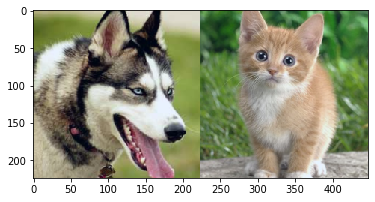

In [5]:
visualize_processed_batch(preprocessed)

In [6]:
import tempfile
import shutil
import os
tmpdir = tempfile.mkdtemp()
resnet_preproc_dir = os.path.join(tmpdir, 'resnet-preproc-v1-18')
os.makedirs(resnet_preproc_dir)
test_data_dir = os.path.join(resnet_preproc_dir, 'test_data_set_0')
os.makedirs(test_data_dir)

In [7]:
# Saving inputs
from onnx.numpy_helper import from_list
for img in images:
    print(img.dtype, img.shape)
seq_input = from_list(images)
seq_input.name = 'images'
print(type(seq_input))
serialized_input = seq_input.SerializeToString()
print(type(serialized_input))
with open(os.path.join(test_data_dir, 'input_0.pb'), "wb") as f:
    f.write(serialized_input)

uint8 (266, 400, 3)
uint8 (348, 348, 3)
<class 'onnx.onnx_data_pb2.SequenceProto'>
<class 'bytes'>


In [8]:
import onnx
from onnx import parser
from onnx import checker

resnet_preproc = parser.parse_model('''
<
  ir_version: 8,
  opset_import: [ "" : 18, "local" : 1 ],
  metadata_props: [ "preprocessing_fn" : "local.preprocess"]
>
resnet_preproc_g (seq(uint8[?, ?, 3]) images) => (float[B, 3, 224, 224] preproc_data)
{
    preproc_data = local.preprocess(images)
}

<
  opset_import: [ "" : 18 ],
  domain: "local",
  doc_string: "Preprocessing function."
>
preprocess (input_batch) => (output_tensor) {
    tmp_seq = SequenceMap <
        body = sample_preprocessing(uint8[?, ?, 3] sample_in) => (float[3, 224, 224] sample_out) {
            target_size = Constant <value = int64[2] {256, 256}> ()
            image_resized = Resize <mode = \"linear\",
                                    antialias = 1,
                                    axes = [0, 1],
                                    keep_aspect_ratio_policy = \"not_smaller\"> (sample_in, , , target_size)

            target_crop = Constant <value = int64[2] {224, 224}> ()
            image_sliced = CenterCropPad <axes = [0, 1]> (image_resized, target_crop)

            kMean = Constant <value = float[3] {123.675, 116.28, 103.53}> ()
            kStddev = Constant <value = float[3] {58.395, 57.12, 57.375}> ()
            im_norm_tmp1 = Cast <to = 1> (image_sliced)
            im_norm_tmp2 = Sub (im_norm_tmp1, kMean)
            im_norm = Div (im_norm_tmp2, kStddev)

            sample_out = Transpose <perm = [2, 0, 1]> (im_norm)
        }
    > (input_batch)
    output_tensor = ConcatFromSequence < axis = 0, new_axis = 1 >(tmp_seq)
}

''')
checker.check_model(resnet_preproc)

In [9]:
resnet_preproc_model_path = os.path.join(resnet_preproc_dir, 'resnet-preproc-v1-18.onnx')
onnx.save(resnet_preproc, resnet_preproc_model_path)

In [10]:
import onnxruntime
session = onnxruntime.InferenceSession(resnet_preproc_model_path, providers=["CPUExecutionProvider"])

2023-03-09 15:46:24.410744860 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x20c5f70__0x28433f0_axes_input'. It is not used by any node and should be removed from the model.
2023-03-09 15:46:24.410769882 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x20c5f70__0x28433f0_k2'. It is not used by any node and should be removed from the model.


Preprocessed data: type=float32 shape=(2, 3, 224, 224)


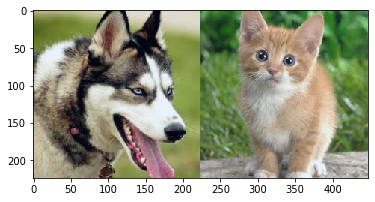

In [11]:
preprocessed_ort = session.run([], {'images': [np.array(image) for image in images]})[0]
print(f"Preprocessed data: type={preprocessed_ort.dtype} shape={preprocessed_ort.shape}")
visualize_processed_batch(preprocessed_ort)

In [12]:
# Saving outputs
from onnx.numpy_helper import from_array
print(preprocessed_ort.dtype, preprocessed_ort.shape)
arr_output = from_array(preprocessed_ort)
arr_output.name = 'preproc_data'
print(type(arr_output))
serialized_output = arr_output.SerializeToString()
print(type(serialized_output))
with open(os.path.join(test_data_dir, 'output_0.pb'), "wb") as f:
    f.write(serialized_output)

float32 (2, 3, 224, 224)
<class 'onnx.onnx_ml_pb2.TensorProto'>
<class 'bytes'>


In [13]:
import tarfile
with tarfile.open('resnet-preproc-v1-18.tar.gz', "w:gz") as archive:
    archive.add(resnet_preproc_dir, arcname='resnet-preproc-v1-18')

# clean 
shutil.rmtree(tmpdir)